## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import gpytorch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt
from os import path

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, VariationalLFM, generate_multioutput_rbf_gp
from lafomo.plot import Plotter
from lafomo.trainers import VariationalTrainer, ParameterPreEstimator
from lafomo.utilities.data import p53_ground_truth
from lafomo.utilities.torch import is_cuda, spline_interpolate_gradient

Let's start by importing our dataset...

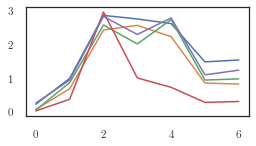

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

Differential equation here: ....

Since this is an ordinary differential equation (ODE), we inherit from the `OrdinaryLFM` class.

In [31]:
from gpytorch.constraints import Positive
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.raw_decay = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_basal = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        f = self.f
        if not self.pretrain_mode:
            f = self.f[:, :, self.t_index].unsqueeze(2)
            if t > self.last_t:
                self.t_index += 1
            self.last_t = t

        dh = self.basal_rate + self.sensitivity * f - self.decay_rate * h
        return dh


In [32]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, 13, 80, dtype=torch.float32)
step_size = 1e-1
num_training = dataset.m_observed.shape[-1]
use_natural = False
gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))

lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)

plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

class P53ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        super().after_epoch()
        # self.cholS.append(self.lfm.q_cholS.detach().clone())
        # self.mus.append(self.lfm.q_m.detach().clone())
        with torch.no_grad():
            # TODO can we replace these with parameter transforms like we did with lengthscale
            # self.lfm.sensitivity.clamp_(0, 20)
            self.lfm.basal_rate.clamp_(0, 20)
            self.lfm.decay_rate.clamp_(0, 20)
            self.lfm.sensitivity[3] = np.float64(1.)
            self.lfm.decay_rate[3] = np.float64(0.8)

track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
use_natural = False
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.03)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.03)]
trainer = P53ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)
pre_estimator = ParameterPreEstimator(lfm, optimizers, dataset, track_parameters=['raw_decay'])

C:\Users\Jacob\Documents\proj\lafomo\lafomo\models\variational_lfm.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


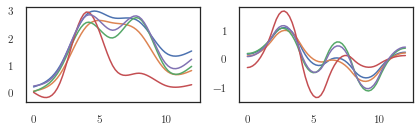

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 2))
pair = pre_estimator.input_pair
for i in range(5):
    axes[0].plot(pair[0], pre_estimator.y_interpolate[i])
    axes[1].plot(pair[0], pre_estimator.target[:, i])
    # axes[1].scatter(t_target, y_grad_target[i])
plt.tight_layout()

In [42]:
# FIRST WE PRETRAIN ON THE INTERPOLATED DERVIATIVE

# x, y = next(iter(trainer.data_loader))
# x = x[0]

lfm.pretrain(True)
pre_estimator.train(100, report_interval=10)

Epoch 201/300 - Loss: 1.42 (-0.59 2.02) kernel: [[[1.2366412]]]
Epoch 211/300 - Loss: 1.31 (-0.74 2.06) kernel: [[[1.2339718]]]
Epoch 221/300 - Loss: 1.26 (-0.83 2.09) kernel: [[[1.2515652]]]
Epoch 231/300 - Loss: 1.19 (-0.92 2.11) kernel: [[[1.2588822]]]
Epoch 241/300 - Loss: 1.17 (-0.94 2.11) kernel: [[[1.2736114]]]
Epoch 251/300 - Loss: 1.17 (-1.01 2.18) kernel: [[[1.2862287]]]
Epoch 261/300 - Loss: 1.17 (-1.01 2.18) kernel: [[[1.2866058]]]
Epoch 271/300 - Loss: 1.20 (-0.98 2.17) kernel: [[[1.2883449]]]
Epoch 281/300 - Loss: 1.07 (-1.14 2.21) kernel: [[[1.2892346]]]
Epoch 291/300 - Loss: 1.12 (-1.07 2.19) kernel: [[[1.3083186]]]


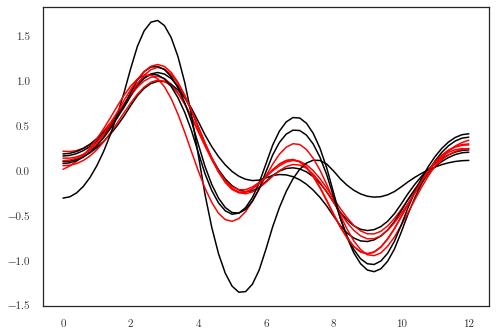

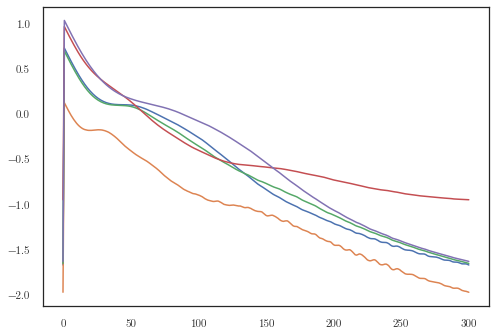

In [43]:
lfm.pretrain(True)
for i in range(5):
    plt.plot(pair[0], pre_estimator.target[:, i], color='black')
    plt.plot(pair[0], lfm(pair).mean.detach()[:, i], color='red')
plt.figure()
plt.plot(torch.stack(pre_estimator.parameter_trace['raw_decay']).squeeze())

In [50]:
lfm.pretrain(False)
trainer.optimizers = pre_estimator.optimizers
trainer.train(100, step_size=1e-1, report_interval=10)

Epoch 101/200 - Loss: 3.69 (1.99 1.70) kernel: [[[1.2457385]]]
Epoch 111/200 - Loss: 3.59 (1.88 1.70) kernel: [[[1.2451408]]]
Epoch 121/200 - Loss: 3.58 (1.87 1.71) kernel: [[[1.2476141]]]
Epoch 131/200 - Loss: 3.29 (1.57 1.72) kernel: [[[1.24852]]]
Epoch 141/200 - Loss: 3.27 (1.55 1.72) kernel: [[[1.2479745]]]
Epoch 151/200 - Loss: 3.17 (1.43 1.74) kernel: [[[1.2465907]]]
Epoch 161/200 - Loss: 3.11 (1.38 1.73) kernel: [[[1.2507445]]]
Epoch 171/200 - Loss: 3.02 (1.26 1.75) kernel: [[[1.2477558]]]
Epoch 181/200 - Loss: 3.03 (1.29 1.75) kernel: [[[1.2473629]]]
Epoch 191/200 - Loss: 2.96 (1.18 1.77) kernel: [[[1.2531929]]]


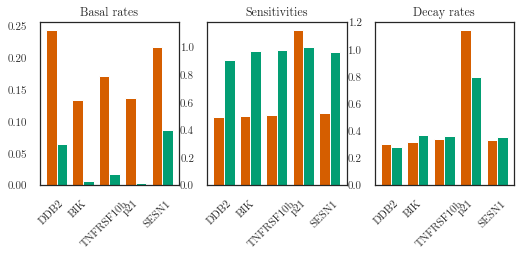

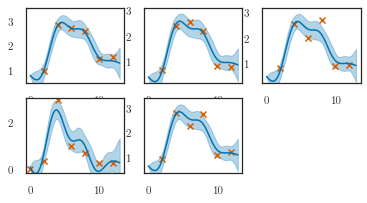

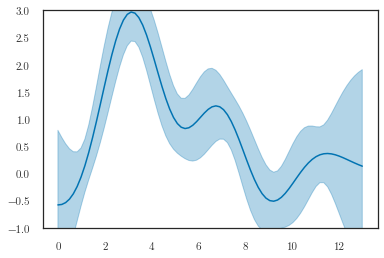

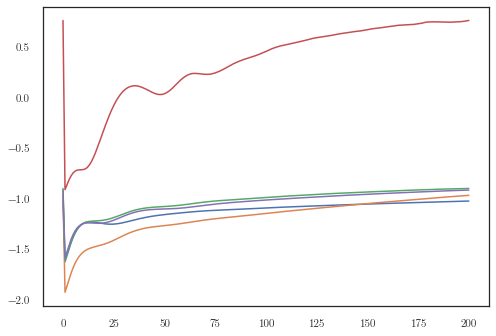

In [51]:
lfm.eval()

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = [lfm.basal_rate.detach(), lfm.sensitivity.detach(), lfm.decay_rate.detach()]
plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
q_m = lfm.predict_m(t_predict)
plotter.plot_gp(q_m, t_predict, num_samples=0, t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)
q_f = lfm.predict_f(t_predict)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))

plt.figure()
plt.plot(torch.stack(trainer.parameter_trace['raw_decay']).squeeze())

In [ ]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_input, train_target, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_input, train_target, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad()
        self.base_kernel.lengthscale = 2.
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

train_input = data[0][0].view(-1, 1)
temp_train_target = torch.stack([
    data[1][0],
    torch.zeros_like(data[1][0]) # TODO [0] is for first time series
], -1)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)  # Value + Derivative
approximating_gp = GPModelWithDerivatives(train_input, temp_train_target, likelihood)
approximating_gp.double()
approximating_gp.train()
likelihood.train()

In [ ]:
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': [
        *approximating_gp.parameters(),
        *lfm.parameters()
    ]},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, approximating_gp)

In [ ]:
approximating_gp.train()
lfm.train()
likelihood.train()

# with torch.no_grad():
#     approximating_gp.covar_module.base_kernel.lengthscale = 2.
def single_epoch(epoch=0):
    optimizer.zero_grad()

    # get gradients at all t
    grads = lfm(x)
    # plt.plot(grads.mean.detach().cumsum(dim=1).permute(1, 0))
    # plt.plot(grads.mean.detach())
    # get approximating GP at all t
    y_target = torch.stack([
            y[0], # values
            y_grad_target[:, 0]
            # grads.mean[:, 0]  # grads TODO [0] is for first time series
    ], -1)
    approximating_gp.set_train_data(
        targets=y_target, strict=False
    )
    out = approximating_gp(approximating_gp.train_inputs[0])
    # plt.plot(out.mean[:, 0].detach())
    print(out.mean.shape, y_target.shape)
    # take loss and step
    log_likelihood, kl_divergence, _ = lfm.loss_fn(grads, y_grad_target)
    lfm_loss = - (log_likelihood - kl_divergence)

    loss = -mll(out, y_target) + lfm_loss

    loss.backward()
    print('Epoch %d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        epoch, loss.item(),
        approximating_gp.covar_module.base_kernel.lengthscale.item(),
        approximating_gp.likelihood.noise.item()
    ))
    # print(lfm.basal_rate.view(-1))
    # print(lfm.decay_rate.view(-1))
    # print(lfm.sensitivity.view(-1))
    optimizer.step()
    with torch.no_grad():
        # TODO can we replace these with parameter transforms like we did with lengthscale
        lfm.sensitivity.clamp_(0, 20)
        lfm.basal_rate.clamp_(0, 20)
        lfm.decay_rate.clamp_(0, 20)
        lfm.sensitivity[3] = np.float64(1.)
        lfm.decay_rate[3] = np.float64(0.8)


for i in range(100):
    single_epoch(i)

In [ ]:
print(lfm.basal_rate.view(-1))
print(lfm.decay_rate.view(-1))
print(lfm.sensitivity.view(-1))
# with torch.no_grad():
#     lfm.sensitivity += 0.3

In [ ]:
approximating_gp.eval()
lfm.eval()
grads = lfm(x)
mean_pred = approximating_gp(t_predict.double()).mean.detach()

print(mean_pred[:, 1].max())
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

axes[0].plot(t_predict, mean_pred[:, 0])
axes[0].scatter(dataset.t_observed, y[0])
axes[1].plot(t_predict, mean_pred[:, 1], label='approx pred')
axes[1].plot(t_interpolate, y_grad[0], label='empirical grad')
axes[1].plot(dataset.t_observed, grads.mean[:, 0].detach(), label='lfm pred')
axes[1].legend()

### Outputs prior to training:

In [ ]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['basal_rate', 'sensitivity', 'decay_rate']:
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=step_size)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')


In [ ]:
lfm.train()

trainer.train(400, report_interval=10, step_size=step_size)


In [ ]:
lfm.eval()
q_m = lfm.predict_m(t_predict, step_size=step_size)
q_f = lfm.predict_f(t_predict)

plotter.plot_losses(trainer, last_x=200)
plotter.plot_gp(q_m, t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-2, 3.2), num_samples=3)
plt.title('Latent')

labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['basal_rate', 'sensitivity', 'decay_rate']:
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())